# Importation des bibliothèques

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Exploration et nettoyage des données

In [34]:
# Charger le dataset
df = pd.read_csv('Housing.csv')

# Afficher les premières lignes
display(df.head())

# Vérifier les valeurs manquantes
print(df.isnull().sum())


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [35]:
# Détection et suppression des outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    if len(outliers) > 0.05 * len(df):
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)], len(outliers)
    return df, 0

# Appliquer la fonction de suppression des outliers sur les colonnes numériques
initial_length = len(df)
total_outliers_removed = 0
for column in df.select_dtypes(include=[np.number]).columns:
    df, outliers_removed = remove_outliers(df, column)
    total_outliers_removed += outliers_removed

# Afficher combien d'outliers ont été supprimés
print(f"Nombre total d'outliers supprimés : {total_outliers_removed}")

# Afficher les premières lignes du dataframe après suppression des outliers
display(df.head())

Nombre total d'outliers supprimés : 41


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished


# 2. Prétraitement des données

In [36]:
# Séparer les variables numériques et catégorielles
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
num_features.remove('price')
cat_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Pipeline de prétraitement
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


# 3. Division en ensemble d'entrainement et de test

In [37]:
# Séparer les données en features et target
X = df.drop(columns=['price'])
y = df['price']

# Diviser en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Création des modèles

In [38]:
# Définir les modèles
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ]),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regression': SVR(),
    'KNN Regression': KNeighborsRegressor()
}

# 5. Entrainement des modèles

In [39]:
# Entraînement et évaluation des modèles
results = {}
overfitting_check = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    results[name] = {
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'R2': r2_score(y_test, y_test_pred)
    }
    
    # Vérifier le surapprentissage
    overfitting_check[name] = abs(train_mse - test_mse)

# Afficher les résultats
df_results = pd.DataFrame(results).T
display(df_results)

# Déterminer le modèle avec le moins de surapprentissage
best_model_name = min(overfitting_check, key=overfitting_check.get)
print(f"Le meilleur modèle sans surapprentissage est : {best_model_name}")

,Train MSE,Test MSE,MAE,R2
Linear Regression,9.684869e+11,1.780066e+12,9.775950e+05,0.573300
Polynomial Regression,5.929118e+11,2.018830e+12,1.001982e+06,0.516065
Ridge Regression,9.685327e+11,1.778663e+12,9.762973e+05,0.573636
Lasso Regression,9.684869e+11,1.780064e+12,9.775937e+05,0.573300
Decision Tree,4.177220e+09,3.182754e+12,1.230856e+06,0.237061
Random Forest,1.697973e+11,1.706894e+12,9.260622e+05,0.590840
Gradient Boosting,4.155340e+11,1.747603e+12,9.580585e+05,0.581081
Support Vector Regression,2.937666e+12,4.296249e+12,1.491299e+06,-0.029856
KNN Regression,8.185284e+11,1.699745e+12,8.884019e+05,0.592553


Le meilleur modèle sans surapprentissage est : Ridge Regression


# 6. Evaluation du meilleur modèle

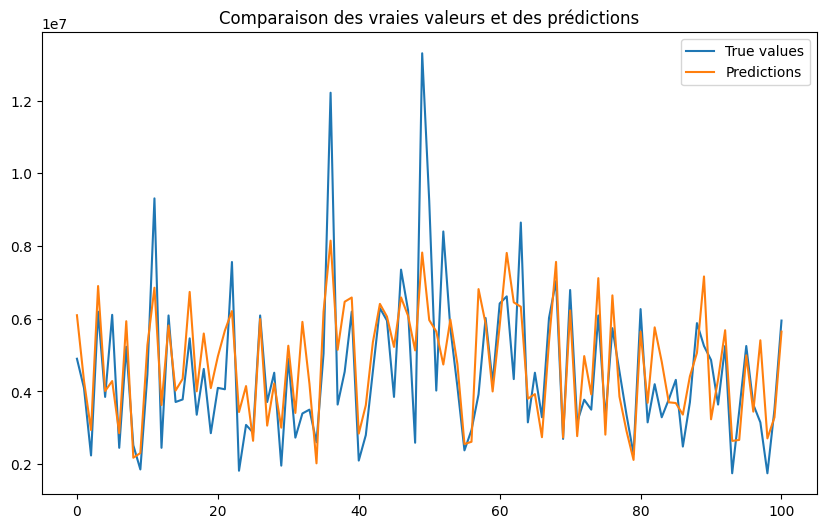

,True Values,Predictions
0,4900000,6096077
1,4095000,4290882
2,2240000,2939681
3,6195000,6899516
4,3850000,4012622
...,...,...
96,3640000,3445330
97,3150000,5407392
98,1750000,2709153
99,3500000,3286017


In [40]:
# Tester des prédictions
best_model = models[best_model_name]
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Formater y_pred en nombre entier
y_pred = np.round(y_pred).astype(int)

# Comparer les vraies valeurs avec les prédictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True values')
plt.plot(y_pred, label='Predictions')
plt.title('Comparaison des vraies valeurs et des prédictions')
plt.legend()
plt.show()

# Créer un DataFrame pour comparer les vraies valeurs et les prédictions
comparison_df = pd.DataFrame({'True Values': y_test.values, 'Predictions': y_pred})
display(comparison_df)

# 7. Sauvegarde du meilleur modèle et du dataset nettoyé

In [41]:
import joblib

# Sauvegarder le pipeline du meilleur modèle
joblib.dump(pipeline, 'best_model_pipeline.joblib')

print("Le meilleur modèle a été sauvegardé avec succès.")

Le meilleur modèle a été sauvegardé avec succès.


In [42]:
# Sauvegarder le dataset nettoyé
df.to_csv('cleaned_housing.csv', index=False)

print("Le dataset nettoyé a été sauvegardé avec succès.")

Le dataset nettoyé a été sauvegardé avec succès.
